In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from glob import glob
import pickle

from PIL import ImageColor
import matplotlib.colors
from sklearn.preprocessing import StandardScaler
from utils import LATENT_FEATURES_DIR, RESULTS_DIR, SUBJECTS, FMRI_BETAS_SURFACE_DIR, STIM_INFO_PATH, COCO_IMAGES_DIR, METRIC_DIFF_MOD_AGNOSTIC_MOD_SPECIFIC, METRIC_CROSS_DECODING, DECODER_ADDITIONAL_TEST_OUT_DIR, SUBJECTS_ADDITIONAL_TEST
from analyses.decoding.ridge_regression_decoding import NUM_CV_SPLITS, pairwise_accuracy
from data import MODALITY_AGNOSTIC, MODALITY_SPECIFIC_IMAGES, MODALITY_SPECIFIC_CAPTIONS, TRAINING_MODES, CAPTION, IMAGE, TEST_SPLITS
from eval import ACC_MODALITY_AGNOSTIC, ACC_CAPTIONS, ACC_IMAGES, ACC_CROSS_IMAGES_TO_CAPTIONS, ACC_CROSS_CAPTIONS_TO_IMAGES, ACC_IMAGERY, ACC_IMAGERY_WHOLE_TEST, get_distance_matrix, dist_mat_to_pairwise_acc
from scipy.stats import ttest_rel
import statsmodels.formula.api as smf



In [3]:
def load_results_data():
    data = []

    result_files = sorted(glob(f"{DECODER_ADDITIONAL_TEST_OUT_DIR}/*/*/*/results.csv"))
    for result_file_path in tqdm(result_files):
        results = pd.read_csv(result_file_path)
        data.append(results)

    data = pd.concat(data, ignore_index=True)
    data["mask"] = data["mask"].fillna("whole_brain")

    return data

data = load_results_data()

# with pd.option_context('display.max_rows', None, 'display.max_columns', None):
display(data)

print(f"Subjects: {data.subject.unique()}")

100%|██████████| 22/22 [00:00<00:00, 101.75it/s]


,metric,value,standardized_predictions,latents,model,subject,features,test_features,vision_features,lang_features,training_mode,training_splits,mask,num_voxels,surface,resolution,imagery_samples_weight
0,test_image,0.901863,True,limited_candidate_latents,imagebind,sub-01,avg,avg,vision_features_cls,lang_features_cls,agnostic,train,whole_brain,133499,False,fsaverage7,NaN
1,test_image,0.896273,False,limited_candidate_latents,imagebind,sub-01,avg,avg,vision_features_cls,lang_features_cls,agnostic,train,whole_brain,133499,False,fsaverage7,NaN
2,test_image,0.903044,True,all_candidate_latents,imagebind,sub-01,avg,avg,vision_features_cls,lang_features_cls,agnostic,train,whole_brain,133499,False,fsaverage7,NaN
3,test_image,0.911358,False,all_candidate_latents,imagebind,sub-01,avg,avg,vision_features_cls,lang_features_cls,agnostic,train,whole_brain,133499,False,fsaverage7,NaN
4,test_caption,0.759627,True,limited_candidate_latents,imagebind,sub-01,avg,avg,vision_features_cls,lang_features_cls,agnostic,train,whole_brain,133499,False,fsaverage7,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
743,imagery_weak,0.899592,True,limited_candidate_latents,imagebind,sub-07,avg,avg,vision_features_cls,lang_features_cls,images,train,whole_brain,327684,True,fsaverage7,NaN
744,imagery_weak,0.648361,False,all_candidate_latents,imagebind,sub-07,avg,avg,vision_features_cls,lang_features_cls,images,train,whole_brain,327684,True,fsaverage7,NaN
745,imagery_weak,0.885574,True,all_candidate_latents,imagebind,sub-07,avg,avg,vision_features_cls,lang_features_cls,images,train,whole_brain,327684,True,fsaverage7,NaN
746,imagery,0.666667,all_imagery,limited_candidate_latents,imagebind,sub-07,avg,avg,vision_features_cls,lang_features_cls,images,train,whole_brain,327684,True,fsaverage7,NaN


Subjects: ['sub-01' 'sub-02' 'sub-07']


In [4]:
print(data[(data.subject == 'sub-01') & (data.model == 'imagebind') & (data.training_mode == 'agnostic') & (data['mask'] == 'whole_brain') & (data.standardized_predictions == 'True') & (data.training_splits == 'train')][['metric', 'value', 'latents']]) #
# print(data[(data.subject == 'sub-01') & (data.model == 'imagebind') & (data.training_mode == 'agnostic') & (data['mask'] == 'whole_brain') & (data.training_splits == 'train') & (data.latents == 'all_candidate_latents')][['metric', 'value', 'latents', 'standardized_predictions']]) #

                     metric     value                    latents
0                test_image  0.901863  limited_candidate_latents
2                test_image  0.903044      all_candidate_latents
4              test_caption  0.759627  limited_candidate_latents
6              test_caption  0.763115      all_candidate_latents
8       test_image_attended  0.905590  limited_candidate_latents
10      test_image_attended  0.907143      all_candidate_latents
12    test_caption_attended  0.817598  limited_candidate_latents
14    test_caption_attended  0.816628      all_candidate_latents
16    test_image_unattended  0.896894  limited_candidate_latents
18    test_image_unattended  0.899180      all_candidate_latents
20  test_caption_unattended  0.628571  limited_candidate_latents
22  test_caption_unattended  0.628220      all_candidate_latents
24                  imagery  1.000000  limited_candidate_latents
26                  imagery  0.844262      all_candidate_latents
28             imagery_we

In [204]:
filtered = data.copy()

LATENT_MODE = 'all_candidate_latents'
# LATENT_MODE = 'limited_candidate_latents'
MASK = 'whole_brain'
TRAINING_SPLITS = 'train'

filtered = filtered[filtered.standardized_predictions == 'True']
filtered = filtered[filtered.training_splits == TRAINING_SPLITS]
filtered = filtered[filtered.latents == LATENT_MODE]
filtered = filtered[filtered['mask'] == MASK]
filtered = filtered[filtered.imagery_samples_weight.isna()]


# print(filtered.groupby(['metric', 'training_mode']).agg(num_subjects=('value', 'size')).reset_index())
NUM_SUBJECTS = 3 # len(ADDITIONAL_TEST_SUBJECTS)
assert len(filtered) == NUM_SUBJECTS * len(filtered.metric.unique()) * len(filtered.training_mode.unique())

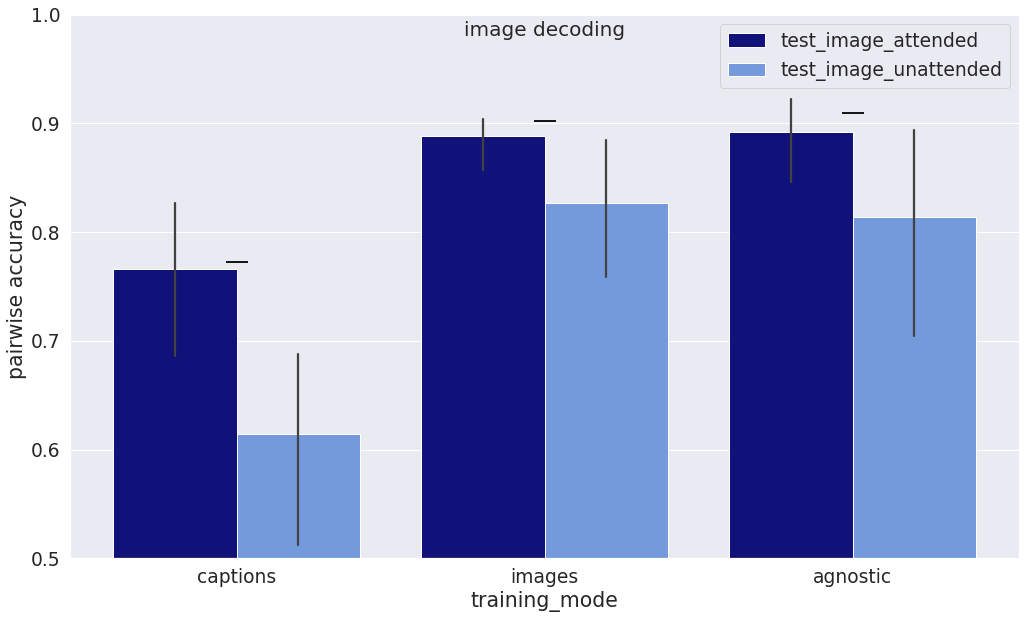

In [233]:
to_plot = filtered.copy()

ORDER = ['captions', 'images', 'agnostic']
HUE_ORDER = ['test_image_attended', 'test_image_unattended']#, 'imagery', 'imagery_weak'] #'test_image', 
PALETTE = ['darkblue', 'cornflowerblue'] #blue

to_plot = to_plot[to_plot.metric.isin(HUE_ORDER)]

sns.set(font_scale=1.7)
plt.figure(figsize=(17, 10))
plt.title('image decoding', y=0.95, fontsize=20)
ax = sns.barplot(data=to_plot, x="training_mode", y="value", hue="metric", order=ORDER, hue_order=HUE_ORDER, palette=PALETTE)
plt.ylim((0.5, 1))
plt.ylabel('pairwise accuracy')


ORDER = ['captions', 'images', 'agnostic']
HUE_ORDER = ['test_image']
to_plot = filtered.copy()
to_plot = to_plot[to_plot.metric.isin(HUE_ORDER)]
to_plot = to_plot.groupby(['training_mode']).agg(value=('value', 'mean')).reset_index()
# display(to_plot)
sns.scatterplot(data=to_plot, x="training_mode", y="value", marker="_", color='black', s=500)

plt.savefig(os.path.join(RESULTS_DIR, f"attention_modulation_images.png"), bbox_inches='tight', pad_inches=0, dpi=300)



## hypothesis: mod-agnostic decoders (and cross-decoding) should suffer more from missing attention

In [187]:
for_stats = to_plot[to_plot.training_mode.isin(['images', 'agnostic'])]
# display(for_stats)
# print(ttest_rel(for_stats[for_stats.metric == 'test_image_attended'].value, for_stats[for_stats.metric == 'test_image_unattended'].value))

for_stats = for_stats[['model', 'subject', 'training_mode', 'value', 'metric']]

mod = smf.mixedlm("value ~ metric * training_mode", for_stats, groups=for_stats["subject"]).fit()

print("=" * 50 + "\nGLM\n" + "=" * 50)
print(mod.summary())
print('pvalues:\n', mod.pvalues)
print('\n')


GLM
                              Mixed Linear Model Regression Results
Model:                            MixedLM                Dependent Variable:                value 
No. Observations:                 12                     Method:                            REML  
No. Groups:                       3                      Scale:                             0.0033
Min. group size:                  4                      Log-Likelihood:                    8.6704
Max. group size:                  4                      Converged:                         Yes   
Mean group size:                  4.0                                                             
--------------------------------------------------------------------------------------------------
                                                        Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------------------------------
Intercept                            

/home/mitja/anaconda3/envs/multimodal_decoding_additional_test/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


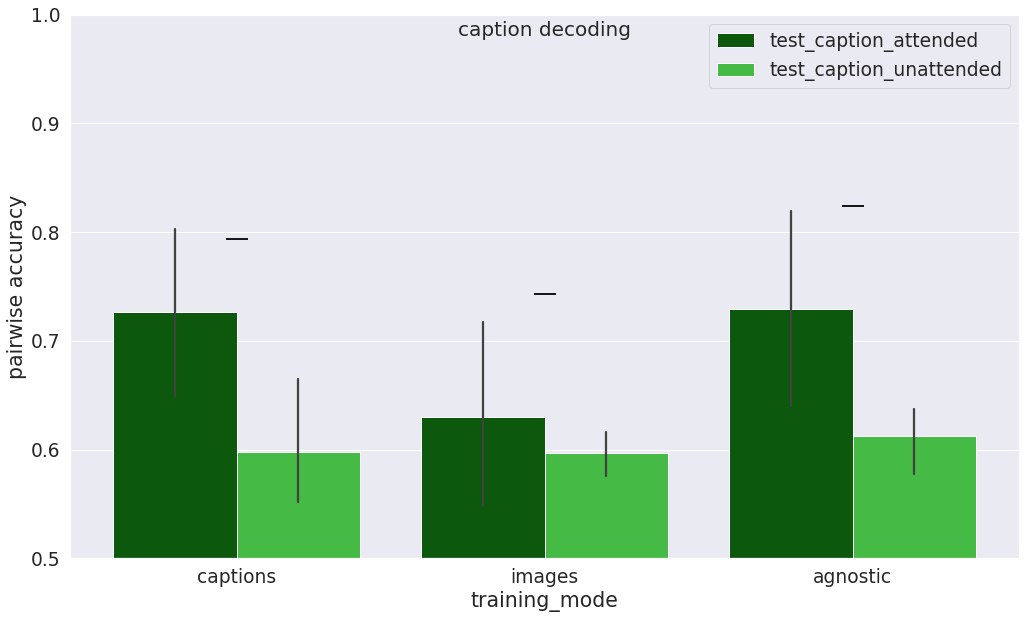

In [237]:
to_plot = filtered.copy()

ORDER = ['captions', 'images', 'agnostic']
HUE_ORDER = ['test_caption_attended', 'test_caption_unattended']#, 'imagery', 'imagery_weak'] #'test_caption', 
PALETTE = ['darkgreen', 'limegreen'] #'green', 

to_plot = to_plot[to_plot.metric.isin(HUE_ORDER)]

sns.set(font_scale=1.7)
plt.figure(figsize=(17,10))
plt.title('caption decoding', y=0.95, fontsize=20)
ax = sns.barplot(data=to_plot, x="training_mode", y="value", hue="metric", order=ORDER, hue_order=HUE_ORDER, palette=PALETTE)
plt.ylabel('pairwise accuracy')
plt.ylim((0.5, 1))

ORDER = ['captions', 'images', 'agnostic']
HUE_ORDER = ['test_caption']
to_plot = filtered.copy()
to_plot = to_plot[to_plot.metric.isin(HUE_ORDER)]
# display(to_plot)
to_plot = to_plot.groupby(['training_mode']).agg(value=('value', 'mean')).reset_index()

sns.scatterplot(data=to_plot, x="training_mode", y="value", marker="_", color='black', s=500)

plt.savefig(os.path.join(RESULTS_DIR, f"attention_modulation_captions.png"), bbox_inches='tight', pad_inches=0, dpi=300)


In [189]:
for_stats = to_plot[to_plot.training_mode.isin(['captions', 'agnostic'])]
display(for_stats)
# print(ttest_rel(for_stats[for_stats.metric == 'test_caption_attended'].value, for_stats[for_stats.metric == 'test_caption_unattended'].value))

for_stats = for_stats[['model', 'subject', 'training_mode', 'value', 'metric']]

mod = smf.mixedlm("value ~ metric * training_mode", for_stats, groups=for_stats["subject"]).fit()

print("=" * 50 + "\nGLM\n" + "=" * 50)
print(mod.summary())
print('pvalues:\n', mod.pvalues)
print('\n')



,metric,value,standardized_predictions,latents,model,subject,features,test_features,vision_features,lang_features,training_mode,training_splits,mask,num_voxels,surface,resolution,imagery_samples_weight
15,test_caption_attended,0.819087,True,all_candidate_latents,imagebind,sub-01,avg,avg,vision_features_cls,lang_features_cls,agnostic,train,whole_brain,327684,True,fsaverage7,NaN
23,test_caption_unattended,0.651874,True,all_candidate_latents,imagebind,sub-01,avg,avg,vision_features_cls,lang_features_cls,agnostic,train,whole_brain,327684,True,fsaverage7,NaN
151,test_caption_attended,0.640281,True,all_candidate_latents,imagebind,sub-02,avg,avg,vision_features_cls,lang_features_cls,agnostic,train,whole_brain,327684,True,fsaverage7,NaN
159,test_caption_unattended,0.608197,True,all_candidate_latents,imagebind,sub-02,avg,avg,vision_features_cls,lang_features_cls,agnostic,train,whole_brain,327684,True,fsaverage7,NaN
287,test_caption_attended,0.728103,True,all_candidate_latents,imagebind,sub-07,avg,avg,vision_features_cls,lang_features_cls,agnostic,train,whole_brain,327684,True,fsaverage7,NaN
295,test_caption_unattended,0.577166,True,all_candidate_latents,imagebind,sub-07,avg,avg,vision_features_cls,lang_features_cls,agnostic,train,whole_brain,327684,True,fsaverage7,NaN
423,test_caption_attended,0.803044,True,all_candidate_latents,imagebind,sub-01,avg,avg,vision_features_cls,lang_features_cls,captions,train,whole_brain,327684,True,fsaverage7,NaN
431,test_caption_unattended,0.664871,True,all_candidate_latents,imagebind,sub-01,avg,avg,vision_features_cls,lang_features_cls,captions,train,whole_brain,327684,True,fsaverage7,NaN
457,test_caption_attended,0.648595,True,all_candidate_latents,imagebind,sub-02,avg,avg,vision_features_cls,lang_features_cls,captions,train,whole_brain,327684,True,fsaverage7,NaN
465,test_caption_unattended,0.551874,True,all_candidate_latents,imagebind,sub-02,avg,avg,vision_features_cls,lang_features_cls,captions,train,whole_brain,327684,True,fsaverage7,NaN


GLM
                                Mixed Linear Model Regression Results
Model:                             MixedLM                 Dependent Variable:                 value  
No. Observations:                  12                      Method:                             REML   
No. Groups:                        3                       Scale:                              0.0011 
Min. group size:                   4                       Log-Likelihood:                     11.0341
Max. group size:                   4                       Converged:                          Yes    
Mean group size:                   4.0                                                                
------------------------------------------------------------------------------------------------------
                                                            Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------------------------------------

/home/mitja/anaconda3/envs/multimodal_decoding_additional_test/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


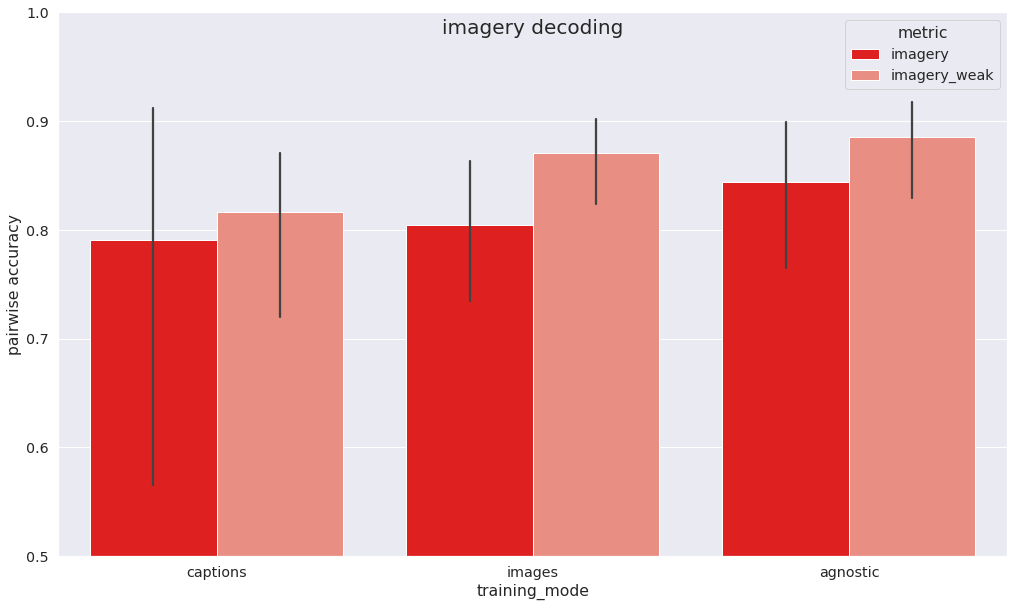

In [174]:
to_plot = filtered.copy()

ORDER = ['captions', 'images', 'agnostic']
HUE_ORDER = ['imagery', 'imagery_weak']
PALETTE = ['red', 'salmon']
sns.set(font_scale=1.3)
plt.figure(figsize=(17,10))
plt.title('imagery decoding', y=0.95, fontsize=20)

ax = sns.barplot(data=to_plot, x="training_mode", y="value", hue="metric", order=ORDER, hue_order=HUE_ORDER, palette=PALETTE)
plt.ylabel('pairwise accuracy')
plt.ylim((0.5, 1))
plt.savefig(os.path.join(RESULTS_DIR, f"attention_modulation_imagery.png"), bbox_inches='tight', pad_inches=0, dpi=300)


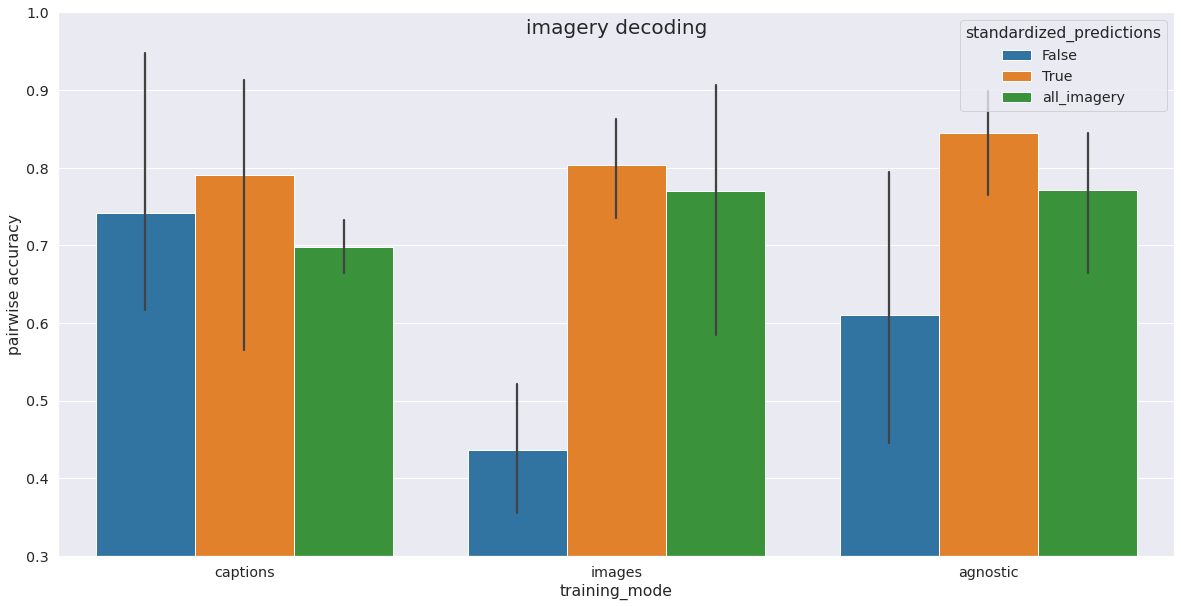

In [198]:
to_plot = data.copy()

LATENT_MODE = 'all_candidate_latents'
# LATENT_MODE = 'limited_candidate_latents'
MASK = 'whole_brain'
TRAINING_SPLITS = 'train'

# to_plot = to_plot[to_plot.standardized_predictions == 'True']
to_plot = to_plot[to_plot.latents == LATENT_MODE]
to_plot = to_plot[to_plot.metric == 'imagery']
to_plot = to_plot[to_plot.training_splits == TRAINING_SPLITS]
to_plot = to_plot[to_plot['mask'] == MASK]

assert len(to_plot) == NUM_SUBJECTS * len(to_plot.standardized_predictions.unique()) * len(to_plot.training_mode.unique())

ORDER = ['captions', 'images', 'agnostic']
HUE_ORDER = None

PALETTE = 'tab10'
sns.set(font_scale=1.3)
plt.figure(figsize=(20,10))
plt.title('imagery decoding', y=0.95, fontsize=20)

ax = sns.barplot(data=to_plot, x="training_mode", y="value", hue="standardized_predictions", order=ORDER, hue_order=HUE_ORDER, palette=PALETTE)
plt.ylabel('pairwise accuracy')
plt.ylim((0.3, 1))
plt.savefig(os.path.join(RESULTS_DIR, f"attention_modulation_imagery.png"), bbox_inches='tight', pad_inches=0, dpi=300)


['train' 'imagery_weak' 'train_imagery_weak']


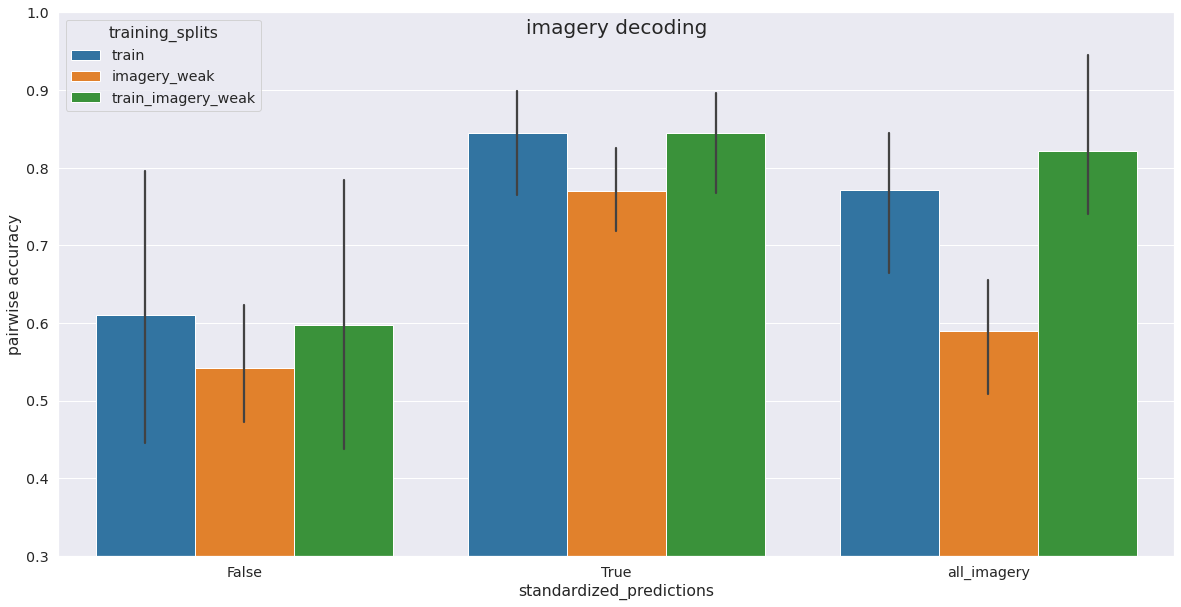

In [191]:
to_plot = data.copy()


LATENT_MODE = 'all_candidate_latents'
# LATENT_MODE = 'limited_candidate_latents'
MASK = 'whole_brain'
TRAINING_SPLITS = 'train'

print(to_plot.training_splits.unique())

# to_plot = to_plot[to_plot.standardized_predictions == 'True']
to_plot = to_plot[to_plot.latents == LATENT_MODE]
to_plot = to_plot[to_plot.metric == 'imagery']
# to_plot = to_plot[to_plot.training_splits == TRAINING_SPLITS]
to_plot = to_plot[to_plot['mask'] == MASK]
to_plot = to_plot[to_plot.training_mode == 'agnostic']
to_plot = to_plot[to_plot.imagery_samples_weight.isna()]

# display(to_plot)
assert len(to_plot) == NUM_SUBJECTS * len(to_plot.standardized_predictions.unique()) * len(to_plot.training_splits.unique()), to_plot

ORDER = None
HUE_ORDER = None

PALETTE = 'tab10'#['red', 'salmon']
sns.set(font_scale=1.3)
plt.figure(figsize=(20,10))
plt.title('imagery decoding', y=0.95, fontsize=20)

ax = sns.barplot(data=to_plot, x="standardized_predictions", y="value", hue="training_splits", order=ORDER, hue_order=HUE_ORDER, palette=PALETTE)
plt.ylabel('pairwise accuracy')
plt.ylim((0.3, 1))
plt.savefig(os.path.join(RESULTS_DIR, f"attention_modulation_imagery.png"), bbox_inches='tight', pad_inches=0, dpi=300)


['train' 'imagery_weak' 'train_imagery_weak']
['1.0' 2.0]


<ipython-input-196-9b5c7bdc5e86>:19: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '1.0' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  to_plot.imagery_samples_weight.fillna('1.0', inplace=True)


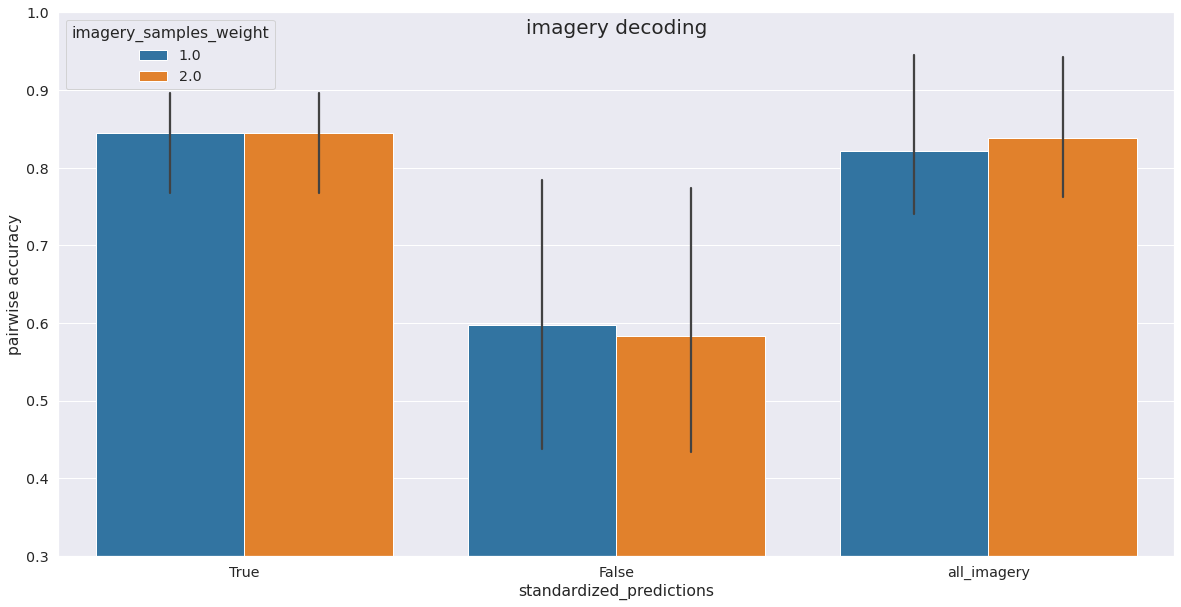

In [196]:
to_plot = data.copy()


LATENT_MODE = 'all_candidate_latents'
# LATENT_MODE = 'limited_candidate_latents'
MASK = 'whole_brain'
TRAINING_SPLITS = 'train_imagery_weak'

print(to_plot.training_splits.unique())

# to_plot = to_plot[to_plot.standardized_predictions == 'True']
to_plot = to_plot[to_plot.latents == LATENT_MODE]
to_plot = to_plot[to_plot.metric == 'imagery']
to_plot = to_plot[to_plot.training_splits == TRAINING_SPLITS]
to_plot = to_plot[to_plot['mask'] == MASK]
to_plot = to_plot[to_plot.training_mode == 'agnostic']
# to_plot = to_plot[to_plot.imagery_samples_weight.isna()]

to_plot.imagery_samples_weight.fillna('1.0', inplace=True)

print(to_plot.imagery_samples_weight.unique())
# display(to_plot)
# assert len(to_plot) == NUM_SUBJECTS * len(to_plot.standardized_predictions.unique()) * len(to_plot.imagery_samples_weight.unique()), to_plot

ORDER = None
HUE_ORDER = None

PALETTE = 'tab10'#['red', 'salmon']
sns.set(font_scale=1.3)
plt.figure(figsize=(20,10))
plt.title('imagery decoding', y=0.95, fontsize=20)

ax = sns.barplot(data=to_plot, x="standardized_predictions", y="value", hue="imagery_samples_weight", order=ORDER, hue_order=HUE_ORDER, palette=PALETTE)
plt.ylabel('pairwise accuracy')
plt.ylim((0.3, 1))
plt.savefig(os.path.join(RESULTS_DIR, f"attention_modulation_imagery.png"), bbox_inches='tight', pad_inches=0, dpi=300)


In [177]:
# data = load_results_data()

# to_plot = data.copy()

# # METRIC = "imagery"
# TRAINING_MODE = 'agnostic'
# # TRAINING_MODE = 'images'
# # TRAINING_MODE = 'captions'

# LATENT_MODE = 'all_candidate_latents'
# # LATENT_MODE = 'limited_candidate_latents'
# # MASK = 'whole_brain'

# TRAINING_SPLITS = 'train'


# to_plot = to_plot[to_plot.standardized_predictions == 'True']
# to_plot = to_plot[to_plot.latents == LATENT_MODE]
# to_plot = to_plot[to_plot.training_splits == TRAINING_SPLITS]
# # to_plot = to_plot[to_plot['mask'] == MASK]

# to_plot = to_plot[to_plot.training_mode == TRAINING_MODE]
# # to_plot = to_plot[to_plot.metric == METRIC]

# def shorten_mask_name(name):
#     if name == "whole_brain":
#         return name
#     return os.path.basename(name)
    
# to_plot["mask"] = to_plot["mask"].apply(shorten_mask_name)


# # print(to_plot.groupby(['metric', 'mask']).agg(num_subjects=('value', 'size')).reset_index())
# assert len(to_plot) == NUM_SUBJECTS * len(to_plot.metric.unique()) * len(to_plot['mask'].unique())


# HUE_ORDER = ['test_image_attended', 'test_image_unattended', 'test_caption_attended', 'test_caption_unattended']#, 'imagery', 'imagery_weak'] #'test_image',  'test_caption',
# PALETTE = ['darkblue', 'cornflowerblue', 'darkgreen', 'limegreen', 'red', 'salmon'] #'blue', 'green'
# sns.set(font_scale=1.3)
# plt.figure(figsize=(30,10))
# ax = sns.barplot(data=to_plot, x="mask", y="value", hue="metric", hue_order=HUE_ORDER, palette=PALETTE)
# plt.ylabel('pairwise accuracy')
# plt.ylim((0.5, 1))
# plt.xticks(rotation=85)
# sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

